# Oppgave 3

## 2)

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, fftfreq, fftshift, ifft, ifftshift
import pandas as pd
from tqdm import tqdm

In [43]:
def plot_stability(r, xlim, ylim, resolution=500):
    
    x = np.linspace(xlim[0], xlim[1], resolution)
    y = np.linspace(ylim[0], ylim[1], resolution)
    X, Y = np.meshgrid(x,y)
    Z = X + 1j*Y
    
    R = np.abs(r(Z))
    
    plt.figure(figsize=(5,5))
    plt.contourf(X, Y, R, levels=[0,1], colors=['blue'], alpha=0.5)
    plt.contour(X, Y, R, levels=[1], colors=['black'])
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title(f'Stabilitetsområde, $θ = {θ}$')
    plt.grid(); plt.show()
    
def r(z):
    return (1+(1-θ)*z)/(1-θ*z)

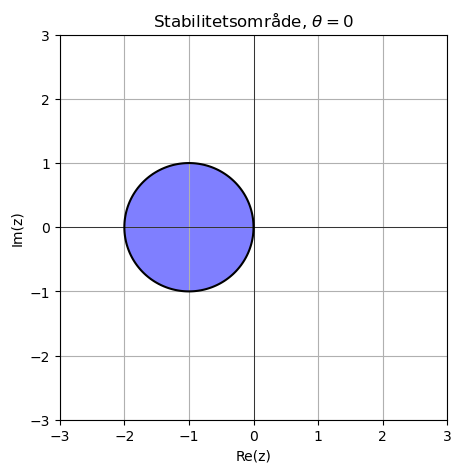

In [11]:
θ = 0

plot_stability(r, xlim=(-3,3), ylim=(-3,3))

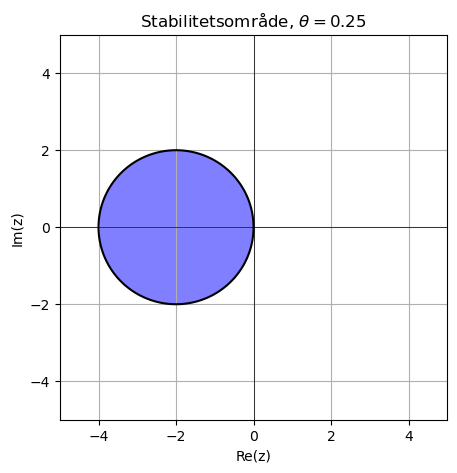

In [14]:
θ = 0.25

plot_stability(r, xlim=(-5,5), ylim=(-5,5))

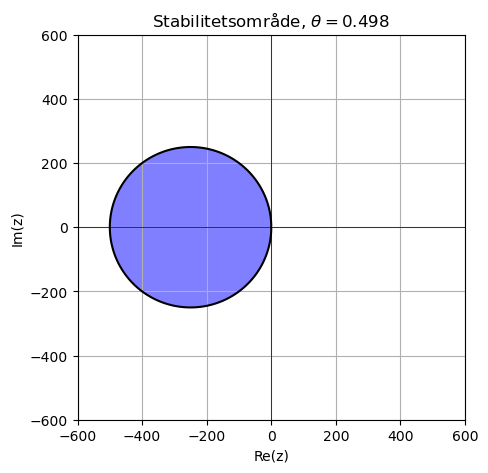

In [20]:
θ = 0.498

plot_stability(r, xlim=(-600,600), ylim=(-600,600))

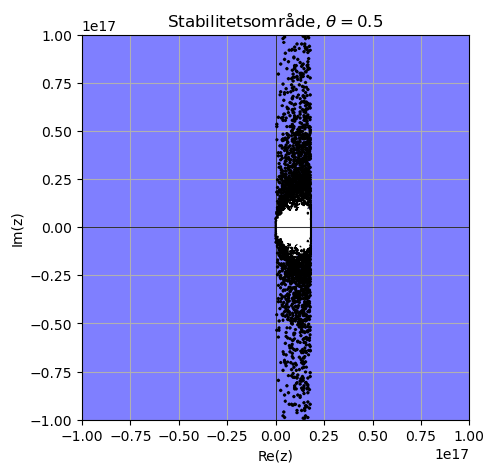

In [32]:
θ = 0.5

plot_stability(r, xlim=(-1e17,1e17), ylim=(-1e17,1e17))

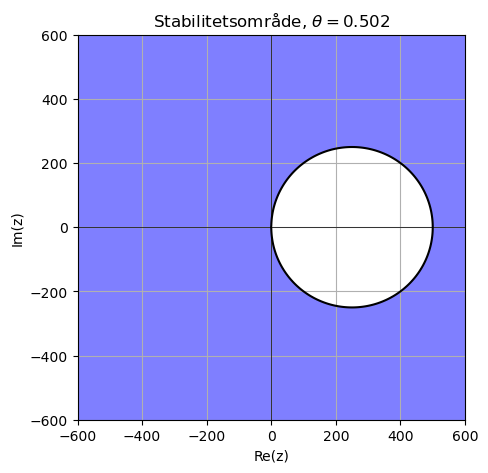

In [33]:
θ = 0.502

plot_stability(r, xlim=(-600,600), ylim=(-600,600))

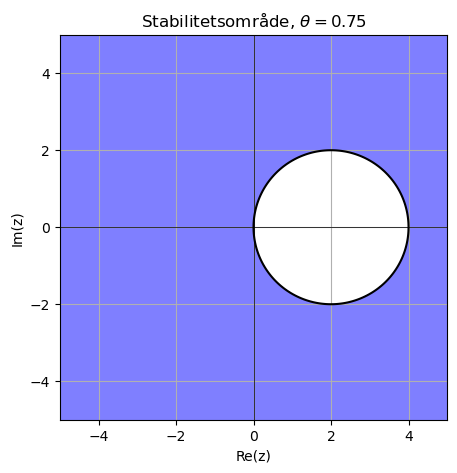

In [42]:
θ = 0.75

plot_stability(r, xlim=(-5,5), ylim=(-5,5))

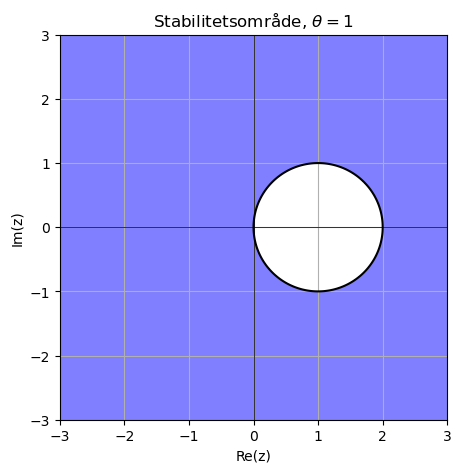

In [40]:
θ = 1

plot_stability(r, xlim=(-3,3), ylim=(-3,3))

# Oppgave 4

## 2)

In [130]:
def cahn_hilliard_backward_euler(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_list = []
    
    U_hat = fft2(U0)
    
    U_list.append((ifft2(U_hat).real, t))
    
    while t < T-dt/2:
        if g is not None:
            G_hat = fft2(g(X,Y,t+dt))
        else:
            G_hat = 0
            
        U = ifft2(U_hat)
        N_U = csgraph.laplacian(np.array(U)**3)
        N_U_hat = fft2(N_U)
        U_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
        
        t += dt
        
        U_list.append((ifft2(U_hat).real, t))
        
    return U_list

In [136]:
def cahn_hilliard_backward_euler(*, kappa, X, Y, U0, t0, T, Nt, g, alpha=1.5):
    x, y = X[0,:], Y[:,0]
    Nx, Ny = len(x), len(y)
    if Nx < 2 or Ny < 2:
        raise ValueError('Grids must have at least two points in each space direction!')
    dx, dy = x[1]-x[0], y[1]-y[0]
    
    kx = fftfreq(Nx, d=dx/(2*np.pi))
    ky = fftfreq(Ny, d=dy/(2*np.pi))
    KX, KY = np.meshgrid(kx, ky, sparse=True)
    K2 = KX**2 + KY**2
    K4 = K2**2
    
    t = t0
    dt = (T-t0)/Nt
    
    U_hat = fft2(U0)
    
    yield(U_hat, t) 
    
    with tqdm(total=T) as pbar:
        while t < T-dt/2:
            if g is not None:
                G_hat = fft2(g(X,Y,t+dt))
            else:
                G_hat = 0
            
            U = ifft2(U_hat)
            N_U = csgraph.laplacian(np.array(U)**3)
            N_U_hat = fft2(N_U)
            U_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
        
            t += dt
            
            yield (U_hat, t)

## 3)

In [131]:
def manufacture_solution_cahn_hilliard(u_str, kappa):
    import sympy as sy
    from sympy import sin, cos, exp
    
    x, y, t = sy.symbols('x y t')
    u_sy = eval(u_str)
    laplace = lambda u: sy.diff(u, x, x) + sy.diff(u, y, y)
    biharmonic = lambda laplace: sy.diff(laplace, x, x) + sy.diff(laplace, y, y)
    g_sy = sy.diff(u_sy, t) - sy.simplify(laplace(u_sy**3-u_sy)) + kappa*sy.simplify(biharmonic(u_sy))
    u = sy.lambdify((x, y, t), u_sy, modules='numpy')
    g = sy.lambdify((x, y, t), g_sy, modules='numpy')
    
    print(f'u = {u_sy}')
    print(f'u0 = {u_sy.subs(t,0)}')
    print(f'g = {g_sy}')
    
    return u, g

In [132]:
kappa = 1.0
u_ex_str = 'sin(x)*cos(y)*exp(-4*kappa*t)'
u_ex, g = manufacture_solution_cahn_hilliard(u_ex_str, kappa)

u = exp(-4.0*t)*sin(x)*cos(y)
u0 = sin(x)*cos(y)
g = -((6 - 9*sin(x)**2)*exp(4.0*t)*cos(y)**2 + (9*sin(y)**2 - 3)*exp(4.0*t)*sin(x)**2 + 2*exp(12.0*t))*exp(-16.0*t)*sin(x)*cos(y) - 6.0*exp(-4.0*t)*sin(x)*cos(y)


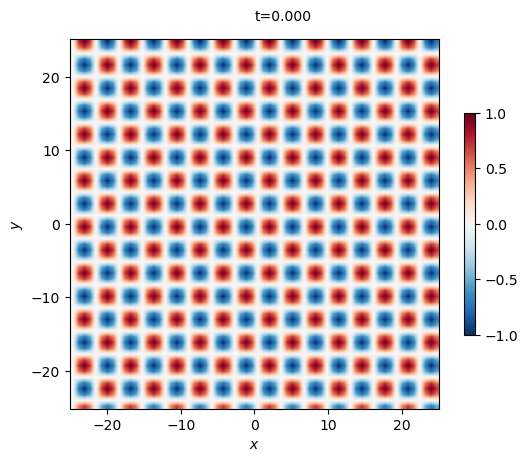

In [50]:
Lx, Ly = 16*np.pi, 16*np.pi
Nx, Ny = 64, 64
x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, sparse=True)
U0 = u_ex(X, Y, 0)

t0, T = 0, 1
Nt = 100

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(U0, cmap='RdBu_r', interpolation='bilinear', extent=[-Lx/2, Lx/2, -Ly/2, Ly/2])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
tx = ax.text(0, Ly/2*1.1, f't={0.0:.3f}', bbox=dict(boxstyle='round', ec='white', fc='white'))
cbar = plt.colorbar(img, ax=ax, shrink=0.6)
cbar.set_ticks(np.linspace(U0.min(), U0.max(), num=5))

In [137]:
def compute_eoc_transient(*, kappa, u_ex, U0, g, X, Y, t0, T, Nt_list):
    errs_Nt = []
    for Nt in Nt_list:
        solver = cahn_hilliard_backward_euler(kappa=kappa, X=X, Y=Y, U0=U0, t0=t0, T=T, Nt=Nt, g=g)
        
        errs_t = []
        for U_hat, t in solver:
            U = ifft2(U_hat).real
            U_ex = u_ex(X,Y,t)
            U_err = U - U_ex
            
            errs_t.append(np.linalg.norm(U_err, np.inf))
            
        errs_Nt.append(np.array(np.linalg.norm(errs_t, np.inf)))
        
    Nt_list = np.array(Nt_list)
    errs_Nt = np.array(errs_Nt)
    eocs = np.log(errs_Nt[1:]/errs_Nt[:-1])/np.log(Nt_list[:-1]/Nt_list[1:])
    eocs = np.insert(eocs, 0, np.inf)
    
    return errs_Nt, eocs

In [138]:
kappa = 1.0
Nt_list = [100,200,400,800,1600,3200]

errs, eocs = compute_eoc_transient(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

  0%|          | 0/1 [00:02<?, ?it/s]


,Nt,error,EOC
0,100,23.435787,inf
1,200,24.901706,-0.087531
2,400,25.663417,-0.043469
3,800,26.052041,-0.021683
4,1600,26.248430,-0.010835
5,3200,26.347136,-0.005415


In [139]:
kappa = 0.01

errs, eocs = compute_eoc_transient(kappa=kappa, u_ex=u_ex, U0=U0, g=g, X=X, Y=Y, t0=t0, T=T, Nt_list=Nt_list)

table = pd.DataFrame({'Nt': Nt_list, 'error': errs, 'EOC': eocs})
display(table)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Jervt\AppData\Local\Temp\ipykernel_31132\762055941.py:31: RuntimeWarning: invalid value encountered in multiply
  U_hat = (U_hat + dt*((1+alpha)*K2*U_hat - K2*N_U_hat + G_hat))/(1 + dt*(kappa*K4 + alpha*K2))
  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Jervt\AppData\Local\Temp\ipykernel_31132\762055941.py:29: RuntimeWarning: overflow encountered in power
  N_U = csgraph.laplacian(np.array(U)**3)
C:\Users\Jervt\AppData\Local\Temp\ipykernel_31132\762055941.py:29: RuntimeWarning: invalid value encountered in power
  N_U = csgraph.laplacian(np.array(U)**3)
C:\Users\Jervt\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Jervt\anaconda3\Lib\site-packages\scipy\sparse\csgraph\_laplacian.py:552: RuntimeWarning: invalid value encountered in multiply
  m *= -1
  0%|          | 0/1 [00:03<?, ?it/s]


,Nt,error,EOC
0,100,NaN,inf
1,200,NaN,NaN
2,400,NaN,NaN
3,800,NaN,NaN
4,1600,NaN,NaN
5,3200,NaN,NaN


# Oppgave 5

## 3)

In [ ]:
kappa = 0.01

In [ ]:
α10 = 3/2
α11 = -1/2
α20 = 0
α21 = 0
α22 = 1
β1 = 1/2
β2 = 1



In [ ]:
α10 = 2
α11 = -1
α20 = 1/2
α21 = 0
α22 = 1/2
β1 = 1
β2 = 1



In [ ]:
α10 = 2
α11 = -1
α20 = 0
α21 = 1/2
α22 = 1/2
β1 = 1
β2 = 1/2



In [ ]:
α10 = 5/2
α11 = -3/2
α20 = 2/3
α21 = 0
α22 = 1/3
β1 = 3/2
β2 = 1

